# Convolution Neural Network Experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
import random

from torch import nn

import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
import warnings
warnings.filterwarnings("ignore")

cuda:0


Set learning rate for all experiments

In [2]:
LR = 0.001

## CIFAR-10 Dataset uploading

In [3]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
    

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(means, stds)
                                                ])


BATCH_SIZE = 64

train_set = torchvision.datasets.CIFAR10('./cifar', train=True, download=True,
                                         transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=4)

test_set = torchvision.datasets.CIFAR10('./cifar', train=False, download=True,
                                         transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                          num_workers=4)

### END Solution (do not delete this comment)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Train size', len(train_set))
print('Test size', len(test_set))


Files already downloaded and verified
Files already downloaded and verified
Train size 50000
Test size 10000


## Train function

In [4]:
def epoch_train(loader, clf, criterion, opt, scheduler):
    loss_sum, correct, k = 0, 0, 0
    clf.train(True)
    for model_input, target in train_loader:
        model_input = model_input.to(device)
        target = target.to(device)
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        opt.zero_grad()
        loss.backward()
        loss_sum += loss
        if scheduler is not None:
            scheduler.step()
        opt.step()
        prediction = model_output.argmax(dim=-1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        k += 1
    train_acc = correct / len(loader.dataset)
    train_loss = loss_sum / k
    return train_loss, train_acc


def epoch_test(loader, clf, criterion):
    clf.eval()
    loss_sum, correct, k = 0, 0, 0
    with torch.no_grad():
         for model_input, target in test_loader:
            model_input = model_input.to(device)
            target = target.to(device)
            model_output = clf(model_input)
            loss = criterion(model_output, target)
            loss_sum += loss
            prediction = model_output.argmax(dim=-1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            k += 1
    test_acc = correct / len(loader.dataset)
    test_loss = loss_sum / k
    return test_loss, test_acc

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50, scheduler=None):
    logging = []
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt, scheduler)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')
        logging.append(np.array([epoch, train_loss.item(), test_loss.item()]))
    return logging

## Class CNN

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(         
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64, 1000),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# Adam

In [6]:
torch.cuda.set_device(0)
clf_cnn = CNN(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_cnn.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_cnn(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10

Number of weights: 4174546


Set updating of learning rate - $\alpha$ with scheduler:

$$ \alpha_t = \frac{\alpha}{\sqrt{t}},$$

where $t$ - number of iteration.

In [7]:
opt = torch.optim.Adam(clf_cnn.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()
lambda1 = lambda epoch: 1/np.sqrt(epoch+1)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

logging_Adam = train(train_loader, test_loader,
                     clf_cnn, criterion, opt, n_epochs=46,
                    scheduler = scheduler)

  2%|█▉                                                                                        | 1/46 [00:09<07:19,  9.76s/it]

[Epoch 1] train loss: 1.248; train acc: 0.56; test loss: 1.062; test acc: 0.63


  4%|███▉                                                                                      | 2/46 [00:19<07:11,  9.80s/it]

[Epoch 2] train loss: 0.878; train acc: 0.70; test loss: 0.978; test acc: 0.66


  7%|█████▊                                                                                    | 3/46 [00:29<06:58,  9.74s/it]

[Epoch 3] train loss: 0.716; train acc: 0.77; test loss: 0.957; test acc: 0.67


  9%|███████▊                                                                                  | 4/46 [00:39<06:49,  9.74s/it]

[Epoch 4] train loss: 0.594; train acc: 0.82; test loss: 0.945; test acc: 0.68


 11%|█████████▊                                                                                | 5/46 [00:48<06:37,  9.69s/it]

[Epoch 5] train loss: 0.493; train acc: 0.86; test loss: 0.939; test acc: 0.68


 13%|███████████▋                                                                              | 6/46 [00:58<06:30,  9.77s/it]

[Epoch 6] train loss: 0.410; train acc: 0.90; test loss: 0.943; test acc: 0.68


 15%|█████████████▋                                                                            | 7/46 [01:07<06:10,  9.51s/it]

[Epoch 7] train loss: 0.340; train acc: 0.93; test loss: 0.950; test acc: 0.68


 17%|███████████████▋                                                                          | 8/46 [01:16<05:58,  9.43s/it]

[Epoch 8] train loss: 0.283; train acc: 0.95; test loss: 0.959; test acc: 0.68


 20%|█████████████████▌                                                                        | 9/46 [01:26<05:51,  9.50s/it]

[Epoch 9] train loss: 0.232; train acc: 0.97; test loss: 0.973; test acc: 0.68


 22%|███████████████████▎                                                                     | 10/46 [01:35<05:36,  9.34s/it]

[Epoch 10] train loss: 0.189; train acc: 0.98; test loss: 0.982; test acc: 0.68


 24%|█████████████████████▎                                                                   | 11/46 [01:44<05:27,  9.36s/it]

[Epoch 11] train loss: 0.155; train acc: 0.99; test loss: 0.994; test acc: 0.68


 26%|███████████████████████▏                                                                 | 12/46 [01:53<05:12,  9.20s/it]

[Epoch 12] train loss: 0.128; train acc: 0.99; test loss: 1.006; test acc: 0.68


 28%|█████████████████████████▏                                                               | 13/46 [02:02<05:03,  9.19s/it]

[Epoch 13] train loss: 0.104; train acc: 1.00; test loss: 1.018; test acc: 0.68


 30%|███████████████████████████                                                              | 14/46 [02:12<04:56,  9.27s/it]

[Epoch 14] train loss: 0.085; train acc: 1.00; test loss: 1.031; test acc: 0.68


 33%|█████████████████████████████                                                            | 15/46 [02:21<04:45,  9.22s/it]

[Epoch 15] train loss: 0.071; train acc: 1.00; test loss: 1.047; test acc: 0.68


 35%|██████████████████████████████▉                                                          | 16/46 [02:30<04:38,  9.27s/it]

[Epoch 16] train loss: 0.059; train acc: 1.00; test loss: 1.065; test acc: 0.68


 37%|████████████████████████████████▉                                                        | 17/46 [02:40<04:30,  9.32s/it]

[Epoch 17] train loss: 0.048; train acc: 1.00; test loss: 1.071; test acc: 0.68


 39%|██████████████████████████████████▊                                                      | 18/46 [02:49<04:20,  9.29s/it]

[Epoch 18] train loss: 0.041; train acc: 1.00; test loss: 1.092; test acc: 0.68


 41%|████████████████████████████████████▊                                                    | 19/46 [02:58<04:10,  9.27s/it]

[Epoch 19] train loss: 0.034; train acc: 1.00; test loss: 1.111; test acc: 0.68


 43%|██████████████████████████████████████▋                                                  | 20/46 [03:08<04:02,  9.35s/it]

[Epoch 20] train loss: 0.029; train acc: 1.00; test loss: 1.124; test acc: 0.68


 46%|████████████████████████████████████████▋                                                | 21/46 [03:17<03:53,  9.33s/it]

[Epoch 21] train loss: 0.024; train acc: 1.00; test loss: 1.139; test acc: 0.68


 48%|██████████████████████████████████████████▌                                              | 22/46 [03:26<03:41,  9.24s/it]

[Epoch 22] train loss: 0.020; train acc: 1.00; test loss: 1.153; test acc: 0.67


 50%|████████████████████████████████████████████▌                                            | 23/46 [03:35<03:33,  9.27s/it]

[Epoch 23] train loss: 0.018; train acc: 1.00; test loss: 1.166; test acc: 0.68


 52%|██████████████████████████████████████████████▍                                          | 24/46 [03:45<03:23,  9.27s/it]

[Epoch 24] train loss: 0.015; train acc: 1.00; test loss: 1.182; test acc: 0.67


 54%|████████████████████████████████████████████████▎                                        | 25/46 [03:54<03:15,  9.29s/it]

[Epoch 25] train loss: 0.013; train acc: 1.00; test loss: 1.200; test acc: 0.68


 57%|██████████████████████████████████████████████████▎                                      | 26/46 [04:03<03:03,  9.16s/it]

[Epoch 26] train loss: 0.011; train acc: 1.00; test loss: 1.210; test acc: 0.68


 59%|████████████████████████████████████████████████████▏                                    | 27/46 [04:12<02:55,  9.26s/it]

[Epoch 27] train loss: 0.010; train acc: 1.00; test loss: 1.222; test acc: 0.68


 61%|██████████████████████████████████████████████████████▏                                  | 28/46 [04:22<02:48,  9.36s/it]

[Epoch 28] train loss: 0.009; train acc: 1.00; test loss: 1.245; test acc: 0.68


 63%|████████████████████████████████████████████████████████                                 | 29/46 [04:31<02:38,  9.34s/it]

[Epoch 29] train loss: 0.008; train acc: 1.00; test loss: 1.251; test acc: 0.68


 65%|██████████████████████████████████████████████████████████                               | 30/46 [04:41<02:31,  9.45s/it]

[Epoch 30] train loss: 0.007; train acc: 1.00; test loss: 1.261; test acc: 0.68


 67%|███████████████████████████████████████████████████████████▉                             | 31/46 [04:50<02:18,  9.26s/it]

[Epoch 31] train loss: 0.006; train acc: 1.00; test loss: 1.270; test acc: 0.68


 70%|█████████████████████████████████████████████████████████████▉                           | 32/46 [04:59<02:07,  9.13s/it]

[Epoch 32] train loss: 0.006; train acc: 1.00; test loss: 1.289; test acc: 0.67


 72%|███████████████████████████████████████████████████████████████▊                         | 33/46 [05:08<01:59,  9.18s/it]

[Epoch 33] train loss: 0.005; train acc: 1.00; test loss: 1.310; test acc: 0.67


 74%|█████████████████████████████████████████████████████████████████▊                       | 34/46 [05:17<01:48,  9.05s/it]

[Epoch 34] train loss: 0.004; train acc: 1.00; test loss: 1.309; test acc: 0.67


 76%|███████████████████████████████████████████████████████████████████▋                     | 35/46 [05:26<01:39,  9.09s/it]

[Epoch 35] train loss: 0.004; train acc: 1.00; test loss: 1.318; test acc: 0.67


 78%|█████████████████████████████████████████████████████████████████████▋                   | 36/46 [05:35<01:30,  9.09s/it]

[Epoch 36] train loss: 0.003; train acc: 1.00; test loss: 1.341; test acc: 0.68


 80%|███████████████████████████████████████████████████████████████████████▌                 | 37/46 [05:44<01:22,  9.13s/it]

[Epoch 37] train loss: 0.003; train acc: 1.00; test loss: 1.336; test acc: 0.67


 83%|█████████████████████████████████████████████████████████████████████████▌               | 38/46 [05:53<01:13,  9.19s/it]

[Epoch 38] train loss: 0.003; train acc: 1.00; test loss: 1.359; test acc: 0.68


 85%|███████████████████████████████████████████████████████████████████████████▍             | 39/46 [06:02<01:03,  9.12s/it]

[Epoch 39] train loss: 0.002; train acc: 1.00; test loss: 1.372; test acc: 0.68


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 40/46 [06:12<00:55,  9.20s/it]

[Epoch 40] train loss: 0.002; train acc: 1.00; test loss: 1.385; test acc: 0.68


 89%|███████████████████████████████████████████████████████████████████████████████▎         | 41/46 [06:21<00:45,  9.14s/it]

[Epoch 41] train loss: 0.002; train acc: 1.00; test loss: 1.393; test acc: 0.68


 91%|█████████████████████████████████████████████████████████████████████████████████▎       | 42/46 [06:31<00:37,  9.37s/it]

[Epoch 42] train loss: 0.002; train acc: 1.00; test loss: 1.410; test acc: 0.67


 93%|███████████████████████████████████████████████████████████████████████████████████▏     | 43/46 [06:40<00:27,  9.29s/it]

[Epoch 43] train loss: 0.002; train acc: 1.00; test loss: 1.409; test acc: 0.68


 96%|█████████████████████████████████████████████████████████████████████████████████████▏   | 44/46 [06:49<00:18,  9.37s/it]

[Epoch 44] train loss: 0.001; train acc: 1.00; test loss: 1.418; test acc: 0.68


 98%|███████████████████████████████████████████████████████████████████████████████████████  | 45/46 [06:59<00:09,  9.41s/it]

[Epoch 45] train loss: 0.001; train acc: 1.00; test loss: 1.439; test acc: 0.68


100%|█████████████████████████████████████████████████████████████████████████████████████████| 46/46 [07:08<00:00,  9.32s/it]

[Epoch 46] train loss: 0.001; train acc: 1.00; test loss: 1.436; test acc: 0.68


## Adagrad

In [8]:
torch.cuda.set_device(0)
clf_cnn = CNN(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_cnn.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_cnn(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10
    
opt = torch.optim.Adagrad(clf_cnn.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

lambda1 = lambda epoch: 1/np.sqrt(epoch+1)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
logging_Adagrad = train(train_loader, test_loader,
                        clf_cnn, criterion, opt, n_epochs=46,
                       scheduler=scheduler)

Number of weights: 4174546


  2%|█▉                                                                                        | 1/46 [00:08<06:06,  8.15s/it]

[Epoch 1] train loss: 1.482; train acc: 0.48; test loss: 1.408; test acc: 0.51


  4%|███▉                                                                                      | 2/46 [00:16<06:00,  8.19s/it]

[Epoch 2] train loss: 1.351; train acc: 0.53; test loss: 1.381; test acc: 0.52


  7%|█████▊                                                                                    | 3/46 [00:24<05:56,  8.28s/it]

[Epoch 3] train loss: 1.327; train acc: 0.54; test loss: 1.369; test acc: 0.52


  9%|███████▊                                                                                  | 4/46 [00:32<05:47,  8.26s/it]

[Epoch 4] train loss: 1.316; train acc: 0.55; test loss: 1.363; test acc: 0.52


 11%|█████████▊                                                                                | 5/46 [00:40<05:34,  8.17s/it]

[Epoch 5] train loss: 1.305; train acc: 0.55; test loss: 1.354; test acc: 0.53


 13%|███████████▋                                                                              | 6/46 [00:48<05:17,  7.94s/it]

[Epoch 6] train loss: 1.296; train acc: 0.56; test loss: 1.349; test acc: 0.53


 15%|█████████████▋                                                                            | 7/46 [00:56<05:06,  7.87s/it]

[Epoch 7] train loss: 1.290; train acc: 0.56; test loss: 1.346; test acc: 0.53


 17%|███████████████▋                                                                          | 8/46 [01:03<04:55,  7.78s/it]

[Epoch 8] train loss: 1.286; train acc: 0.56; test loss: 1.341; test acc: 0.53


 20%|█████████████████▌                                                                        | 9/46 [01:11<04:50,  7.85s/it]

[Epoch 9] train loss: 1.282; train acc: 0.56; test loss: 1.340; test acc: 0.53


 22%|███████████████████▎                                                                     | 10/46 [01:19<04:42,  7.85s/it]

[Epoch 10] train loss: 1.277; train acc: 0.56; test loss: 1.337; test acc: 0.53


 24%|█████████████████████▎                                                                   | 11/46 [01:27<04:34,  7.85s/it]

[Epoch 11] train loss: 1.274; train acc: 0.56; test loss: 1.332; test acc: 0.54


 26%|███████████████████████▏                                                                 | 12/46 [01:35<04:30,  7.94s/it]

[Epoch 12] train loss: 1.270; train acc: 0.57; test loss: 1.333; test acc: 0.53


 28%|█████████████████████████▏                                                               | 13/46 [01:43<04:25,  8.05s/it]

[Epoch 13] train loss: 1.268; train acc: 0.57; test loss: 1.332; test acc: 0.53


 30%|███████████████████████████                                                              | 14/46 [01:52<04:18,  8.08s/it]

[Epoch 14] train loss: 1.265; train acc: 0.57; test loss: 1.328; test acc: 0.54


 33%|█████████████████████████████                                                            | 15/46 [02:00<04:11,  8.13s/it]

[Epoch 15] train loss: 1.262; train acc: 0.57; test loss: 1.330; test acc: 0.54


 35%|██████████████████████████████▉                                                          | 16/46 [02:08<04:04,  8.14s/it]

[Epoch 16] train loss: 1.259; train acc: 0.57; test loss: 1.326; test acc: 0.54


 37%|████████████████████████████████▉                                                        | 17/46 [02:17<03:59,  8.26s/it]

[Epoch 17] train loss: 1.258; train acc: 0.57; test loss: 1.326; test acc: 0.54


 39%|██████████████████████████████████▊                                                      | 18/46 [02:25<03:53,  8.35s/it]

[Epoch 18] train loss: 1.256; train acc: 0.57; test loss: 1.322; test acc: 0.54


 41%|████████████████████████████████████▊                                                    | 19/46 [02:33<03:42,  8.23s/it]

[Epoch 19] train loss: 1.255; train acc: 0.57; test loss: 1.322; test acc: 0.54


 43%|██████████████████████████████████████▋                                                  | 20/46 [02:42<03:35,  8.31s/it]

[Epoch 20] train loss: 1.253; train acc: 0.57; test loss: 1.321; test acc: 0.54


 46%|████████████████████████████████████████▋                                                | 21/46 [02:50<03:25,  8.24s/it]

[Epoch 21] train loss: 1.253; train acc: 0.57; test loss: 1.321; test acc: 0.54


 48%|██████████████████████████████████████████▌                                              | 22/46 [02:58<03:15,  8.16s/it]

[Epoch 22] train loss: 1.250; train acc: 0.57; test loss: 1.318; test acc: 0.54


 50%|████████████████████████████████████████████▌                                            | 23/46 [03:05<03:04,  8.02s/it]

[Epoch 23] train loss: 1.249; train acc: 0.57; test loss: 1.319; test acc: 0.54


 52%|██████████████████████████████████████████████▍                                          | 24/46 [03:13<02:56,  8.01s/it]

[Epoch 24] train loss: 1.248; train acc: 0.57; test loss: 1.314; test acc: 0.54


 54%|████████████████████████████████████████████████▎                                        | 25/46 [03:22<02:50,  8.10s/it]

[Epoch 25] train loss: 1.245; train acc: 0.58; test loss: 1.313; test acc: 0.54


 57%|██████████████████████████████████████████████████▎                                      | 26/46 [03:29<02:40,  8.04s/it]

[Epoch 26] train loss: 1.246; train acc: 0.58; test loss: 1.314; test acc: 0.54


 59%|████████████████████████████████████████████████████▏                                    | 27/46 [03:37<02:32,  8.02s/it]

[Epoch 27] train loss: 1.243; train acc: 0.58; test loss: 1.313; test acc: 0.54


 61%|██████████████████████████████████████████████████████▏                                  | 28/46 [03:46<02:26,  8.13s/it]

[Epoch 28] train loss: 1.242; train acc: 0.58; test loss: 1.315; test acc: 0.54


 63%|████████████████████████████████████████████████████████                                 | 29/46 [03:54<02:19,  8.19s/it]

[Epoch 29] train loss: 1.242; train acc: 0.58; test loss: 1.310; test acc: 0.54


 65%|██████████████████████████████████████████████████████████                               | 30/46 [04:02<02:09,  8.10s/it]

[Epoch 30] train loss: 1.240; train acc: 0.58; test loss: 1.312; test acc: 0.54


 67%|███████████████████████████████████████████████████████████▉                             | 31/46 [04:10<02:00,  8.06s/it]

[Epoch 31] train loss: 1.240; train acc: 0.58; test loss: 1.319; test acc: 0.54


 70%|█████████████████████████████████████████████████████████████▉                           | 32/46 [04:18<01:52,  8.01s/it]

[Epoch 32] train loss: 1.239; train acc: 0.58; test loss: 1.308; test acc: 0.54


 72%|███████████████████████████████████████████████████████████████▊                         | 33/46 [04:26<01:44,  8.02s/it]

[Epoch 33] train loss: 1.239; train acc: 0.58; test loss: 1.308; test acc: 0.54


 74%|█████████████████████████████████████████████████████████████████▊                       | 34/46 [04:34<01:35,  7.96s/it]

[Epoch 34] train loss: 1.236; train acc: 0.58; test loss: 1.310; test acc: 0.54


 76%|███████████████████████████████████████████████████████████████████▋                     | 35/46 [04:42<01:28,  8.01s/it]

[Epoch 35] train loss: 1.236; train acc: 0.58; test loss: 1.309; test acc: 0.54


 78%|█████████████████████████████████████████████████████████████████████▋                   | 36/46 [04:50<01:21,  8.10s/it]

[Epoch 36] train loss: 1.236; train acc: 0.58; test loss: 1.305; test acc: 0.54


 80%|███████████████████████████████████████████████████████████████████████▌                 | 37/46 [04:59<01:13,  8.16s/it]

[Epoch 37] train loss: 1.235; train acc: 0.58; test loss: 1.305; test acc: 0.54


 83%|█████████████████████████████████████████████████████████████████████████▌               | 38/46 [05:06<01:04,  8.04s/it]

[Epoch 38] train loss: 1.233; train acc: 0.58; test loss: 1.307; test acc: 0.54


 85%|███████████████████████████████████████████████████████████████████████████▍             | 39/46 [05:14<00:56,  8.04s/it]

[Epoch 39] train loss: 1.233; train acc: 0.58; test loss: 1.306; test acc: 0.54


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 40/46 [05:22<00:48,  8.05s/it]

[Epoch 40] train loss: 1.232; train acc: 0.58; test loss: 1.307; test acc: 0.54


 89%|███████████████████████████████████████████████████████████████████████████████▎         | 41/46 [05:31<00:40,  8.07s/it]

[Epoch 41] train loss: 1.231; train acc: 0.58; test loss: 1.305; test acc: 0.54


 91%|█████████████████████████████████████████████████████████████████████████████████▎       | 42/46 [05:39<00:32,  8.15s/it]

[Epoch 42] train loss: 1.230; train acc: 0.58; test loss: 1.306; test acc: 0.54


 93%|███████████████████████████████████████████████████████████████████████████████████▏     | 43/46 [05:47<00:24,  8.08s/it]

[Epoch 43] train loss: 1.229; train acc: 0.58; test loss: 1.303; test acc: 0.55


 96%|█████████████████████████████████████████████████████████████████████████████████████▏   | 44/46 [05:55<00:16,  8.09s/it]

[Epoch 44] train loss: 1.228; train acc: 0.58; test loss: 1.303; test acc: 0.54


 98%|███████████████████████████████████████████████████████████████████████████████████████  | 45/46 [06:03<00:08,  8.12s/it]

[Epoch 45] train loss: 1.227; train acc: 0.58; test loss: 1.305; test acc: 0.54


100%|█████████████████████████████████████████████████████████████████████████████████████████| 46/46 [06:11<00:00,  8.07s/it]

[Epoch 46] train loss: 1.227; train acc: 0.58; test loss: 1.300; test acc: 0.55


## SGDNesterov

In [9]:
torch.cuda.set_device(0)
clf_cnn = CNN(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_cnn.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_cnn(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10
    
opt = torch.optim.SGD(clf_cnn.parameters(), lr=LR, nesterov=True, momentum=0.95)
criterion = torch.nn.CrossEntropyLoss()
lambda1 = lambda epoch: 1/np.sqrt(epoch+1)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

logging_SGDNesterov = train(train_loader, test_loader,
                            clf_cnn, criterion, opt, n_epochs=46,
                           scheduler=scheduler)

Number of weights: 4174546


  2%|█▉                                                                                        | 1/46 [00:07<05:48,  7.75s/it]

[Epoch 1] train loss: 1.478; train acc: 0.48; test loss: 1.301; test acc: 0.54


  4%|███▉                                                                                      | 2/46 [00:15<05:36,  7.65s/it]

[Epoch 2] train loss: 1.225; train acc: 0.57; test loss: 1.213; test acc: 0.57


  7%|█████▊                                                                                    | 3/46 [00:22<05:21,  7.47s/it]

[Epoch 3] train loss: 1.139; train acc: 0.61; test loss: 1.165; test acc: 0.59


  9%|███████▊                                                                                  | 4/46 [00:30<05:13,  7.47s/it]

[Epoch 4] train loss: 1.080; train acc: 0.63; test loss: 1.134; test acc: 0.60


 11%|█████████▊                                                                                | 5/46 [00:37<05:11,  7.60s/it]

[Epoch 5] train loss: 1.039; train acc: 0.65; test loss: 1.103; test acc: 0.61


 13%|███████████▋                                                                              | 6/46 [00:45<05:03,  7.60s/it]

[Epoch 6] train loss: 1.006; train acc: 0.66; test loss: 1.080; test acc: 0.62


 15%|█████████████▋                                                                            | 7/46 [00:53<04:57,  7.64s/it]

[Epoch 7] train loss: 0.973; train acc: 0.67; test loss: 1.061; test acc: 0.62


 17%|███████████████▋                                                                          | 8/46 [01:00<04:49,  7.63s/it]

[Epoch 8] train loss: 0.947; train acc: 0.68; test loss: 1.049; test acc: 0.63


 20%|█████████████████▌                                                                        | 9/46 [01:08<04:44,  7.69s/it]

[Epoch 9] train loss: 0.928; train acc: 0.69; test loss: 1.038; test acc: 0.63


 22%|███████████████████▎                                                                     | 10/46 [01:15<04:31,  7.55s/it]

[Epoch 10] train loss: 0.906; train acc: 0.70; test loss: 1.026; test acc: 0.64


 24%|█████████████████████▎                                                                   | 11/46 [01:23<04:22,  7.49s/it]

[Epoch 11] train loss: 0.887; train acc: 0.70; test loss: 1.016; test acc: 0.64


 26%|███████████████████████▏                                                                 | 12/46 [01:30<04:16,  7.53s/it]

[Epoch 12] train loss: 0.872; train acc: 0.71; test loss: 1.008; test acc: 0.65


 28%|█████████████████████████▏                                                               | 13/46 [01:38<04:08,  7.54s/it]

[Epoch 13] train loss: 0.856; train acc: 0.72; test loss: 0.996; test acc: 0.65


 30%|███████████████████████████                                                              | 14/46 [01:45<04:01,  7.55s/it]

[Epoch 14] train loss: 0.841; train acc: 0.72; test loss: 0.991; test acc: 0.65


 33%|█████████████████████████████                                                            | 15/46 [01:53<03:55,  7.59s/it]

[Epoch 15] train loss: 0.830; train acc: 0.72; test loss: 0.984; test acc: 0.66


 35%|██████████████████████████████▉                                                          | 16/46 [02:01<03:47,  7.58s/it]

[Epoch 16] train loss: 0.814; train acc: 0.73; test loss: 0.977; test acc: 0.66


 37%|████████████████████████████████▉                                                        | 17/46 [02:08<03:39,  7.57s/it]

[Epoch 17] train loss: 0.803; train acc: 0.73; test loss: 0.974; test acc: 0.66


 39%|██████████████████████████████████▊                                                      | 18/46 [02:16<03:34,  7.66s/it]

[Epoch 18] train loss: 0.792; train acc: 0.74; test loss: 0.964; test acc: 0.66


 41%|████████████████████████████████████▊                                                    | 19/46 [02:24<03:27,  7.68s/it]

[Epoch 19] train loss: 0.782; train acc: 0.74; test loss: 0.965; test acc: 0.66


 43%|██████████████████████████████████████▋                                                  | 20/46 [02:31<03:18,  7.63s/it]

[Epoch 20] train loss: 0.772; train acc: 0.75; test loss: 0.957; test acc: 0.67


 46%|████████████████████████████████████████▋                                                | 21/46 [02:39<03:08,  7.55s/it]

[Epoch 21] train loss: 0.763; train acc: 0.75; test loss: 0.955; test acc: 0.66


 48%|██████████████████████████████████████████▌                                              | 22/46 [02:46<03:01,  7.56s/it]

[Epoch 22] train loss: 0.750; train acc: 0.75; test loss: 0.949; test acc: 0.67


 50%|████████████████████████████████████████████▌                                            | 23/46 [02:54<02:54,  7.59s/it]

[Epoch 23] train loss: 0.743; train acc: 0.76; test loss: 0.945; test acc: 0.67


 52%|██████████████████████████████████████████████▍                                          | 24/46 [03:02<02:47,  7.59s/it]

[Epoch 24] train loss: 0.734; train acc: 0.76; test loss: 0.946; test acc: 0.67


 54%|████████████████████████████████████████████████▎                                        | 25/46 [03:09<02:38,  7.53s/it]

[Epoch 25] train loss: 0.727; train acc: 0.76; test loss: 0.940; test acc: 0.67


 57%|██████████████████████████████████████████████████▎                                      | 26/46 [03:16<02:29,  7.47s/it]

[Epoch 26] train loss: 0.717; train acc: 0.77; test loss: 0.936; test acc: 0.67


 59%|████████████████████████████████████████████████████▏                                    | 27/46 [03:24<02:25,  7.65s/it]

[Epoch 27] train loss: 0.709; train acc: 0.77; test loss: 0.932; test acc: 0.67


 61%|██████████████████████████████████████████████████████▏                                  | 28/46 [03:32<02:17,  7.65s/it]

[Epoch 28] train loss: 0.702; train acc: 0.77; test loss: 0.930; test acc: 0.67


 63%|████████████████████████████████████████████████████████                                 | 29/46 [03:40<02:09,  7.63s/it]

[Epoch 29] train loss: 0.695; train acc: 0.77; test loss: 0.927; test acc: 0.68


 65%|██████████████████████████████████████████████████████████                               | 30/46 [03:47<02:01,  7.57s/it]

[Epoch 30] train loss: 0.689; train acc: 0.78; test loss: 0.928; test acc: 0.68


 67%|███████████████████████████████████████████████████████████▉                             | 31/46 [03:55<01:54,  7.62s/it]

[Epoch 31] train loss: 0.681; train acc: 0.78; test loss: 0.931; test acc: 0.67


 70%|█████████████████████████████████████████████████████████████▉                           | 32/46 [04:02<01:45,  7.52s/it]

[Epoch 32] train loss: 0.672; train acc: 0.78; test loss: 0.924; test acc: 0.68


 72%|███████████████████████████████████████████████████████████████▊                         | 33/46 [04:10<01:37,  7.52s/it]

[Epoch 33] train loss: 0.668; train acc: 0.79; test loss: 0.922; test acc: 0.68


 74%|█████████████████████████████████████████████████████████████████▊                       | 34/46 [04:17<01:29,  7.45s/it]

[Epoch 34] train loss: 0.660; train acc: 0.79; test loss: 0.919; test acc: 0.68


 76%|███████████████████████████████████████████████████████████████████▋                     | 35/46 [04:24<01:22,  7.48s/it]

[Epoch 35] train loss: 0.654; train acc: 0.79; test loss: 0.914; test acc: 0.68


 78%|█████████████████████████████████████████████████████████████████████▋                   | 36/46 [04:32<01:16,  7.65s/it]

[Epoch 36] train loss: 0.648; train acc: 0.79; test loss: 0.920; test acc: 0.68


 80%|███████████████████████████████████████████████████████████████████████▌                 | 37/46 [04:40<01:08,  7.63s/it]

[Epoch 37] train loss: 0.641; train acc: 0.80; test loss: 0.911; test acc: 0.68


 83%|█████████████████████████████████████████████████████████████████████████▌               | 38/46 [04:47<00:59,  7.41s/it]

[Epoch 38] train loss: 0.636; train acc: 0.80; test loss: 0.913; test acc: 0.68


 85%|███████████████████████████████████████████████████████████████████████████▍             | 39/46 [04:54<00:52,  7.45s/it]

[Epoch 39] train loss: 0.628; train acc: 0.80; test loss: 0.913; test acc: 0.68


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 40/46 [05:02<00:44,  7.44s/it]

[Epoch 40] train loss: 0.623; train acc: 0.80; test loss: 0.911; test acc: 0.68


 89%|███████████████████████████████████████████████████████████████████████████████▎         | 41/46 [05:09<00:36,  7.40s/it]

[Epoch 41] train loss: 0.620; train acc: 0.80; test loss: 0.906; test acc: 0.68


 91%|█████████████████████████████████████████████████████████████████████████████████▎       | 42/46 [05:17<00:29,  7.42s/it]

[Epoch 42] train loss: 0.612; train acc: 0.81; test loss: 0.907; test acc: 0.68


 93%|███████████████████████████████████████████████████████████████████████████████████▏     | 43/46 [05:24<00:22,  7.52s/it]

[Epoch 43] train loss: 0.607; train acc: 0.81; test loss: 0.904; test acc: 0.68


 96%|█████████████████████████████████████████████████████████████████████████████████████▏   | 44/46 [05:32<00:14,  7.48s/it]

[Epoch 44] train loss: 0.602; train acc: 0.81; test loss: 0.911; test acc: 0.68


 98%|███████████████████████████████████████████████████████████████████████████████████████  | 45/46 [05:39<00:07,  7.51s/it]

[Epoch 45] train loss: 0.597; train acc: 0.81; test loss: 0.905; test acc: 0.68


100%|█████████████████████████████████████████████████████████████████████████████████████████| 46/46 [05:47<00:00,  7.55s/it]

[Epoch 46] train loss: 0.591; train acc: 0.82; test loss: 0.903; test acc: 0.68


## CNN without dropout: Optimizers comparing plot

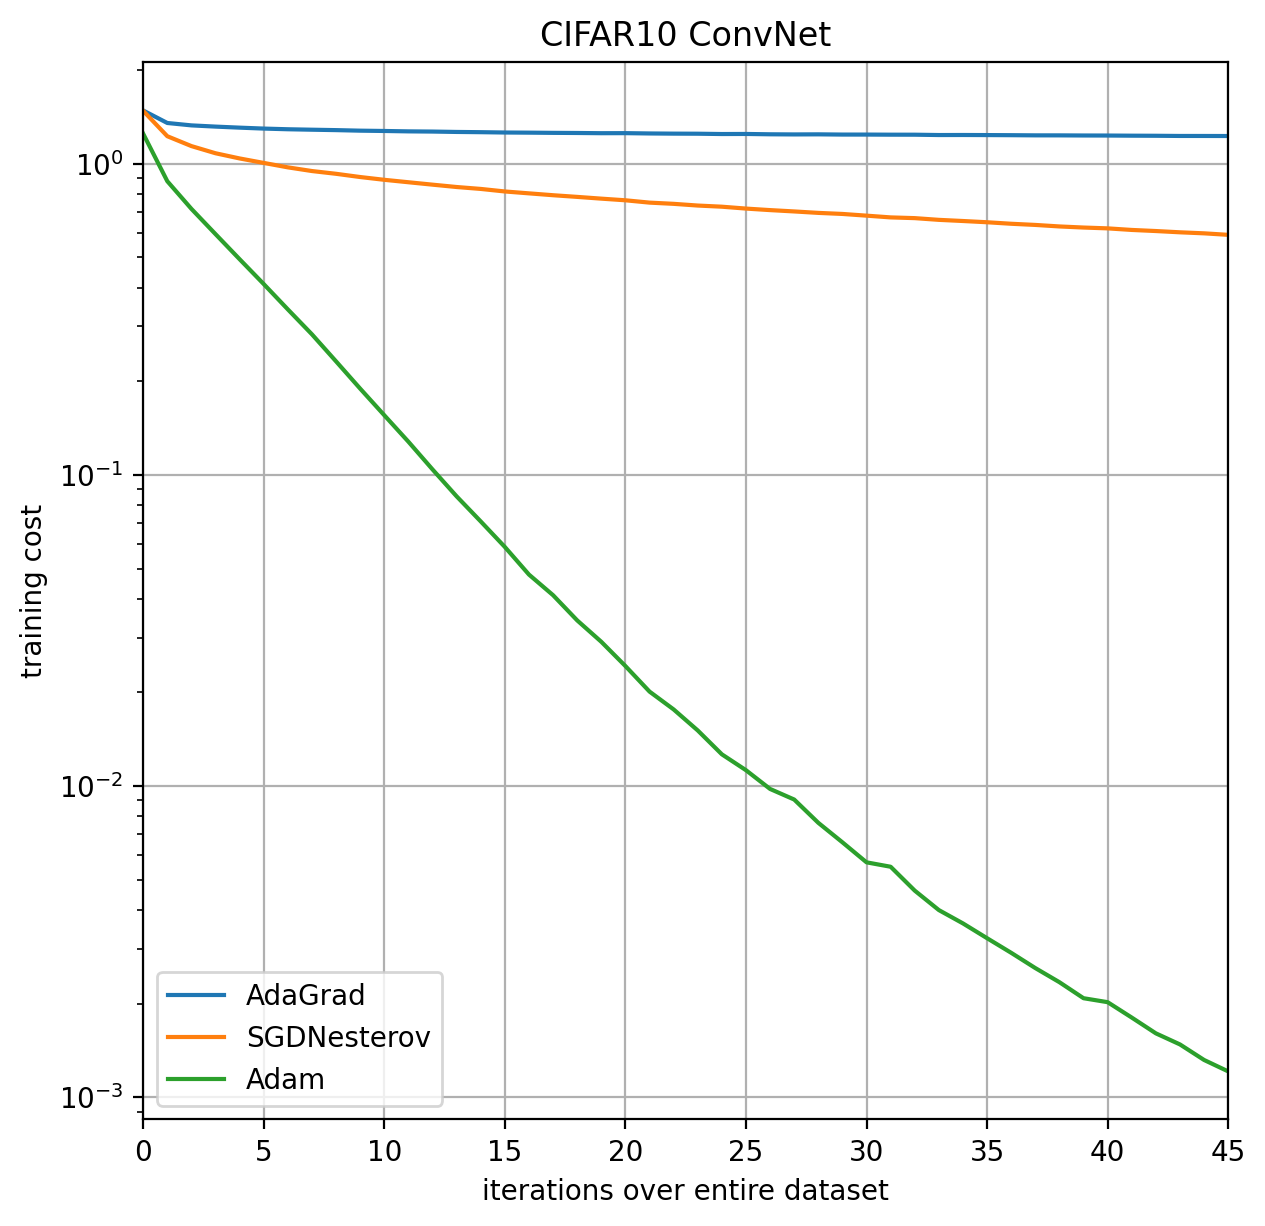

In [10]:
logs = [np.array(logging_Adagrad), np.array(logging_SGDNesterov), np.array(logging_Adam)]
names = ['AdaGrad', 'SGDNesterov', 'Adam']

plt.figure(figsize=(7,7), dpi=200)
for log,name in zip(logs, names):
    plt.plot(log[:,0], log[:,1], label=name)
plt.grid(True)
plt.legend()
plt.title('CIFAR10 ConvNet')
plt.xlabel('iterations over entire dataset')
plt.ylabel('training cost')
plt.xlim(0,45)
# plt.ylim(0.2)
plt.yscale('log')
plt.savefig('fig3b.png')
plt.show()

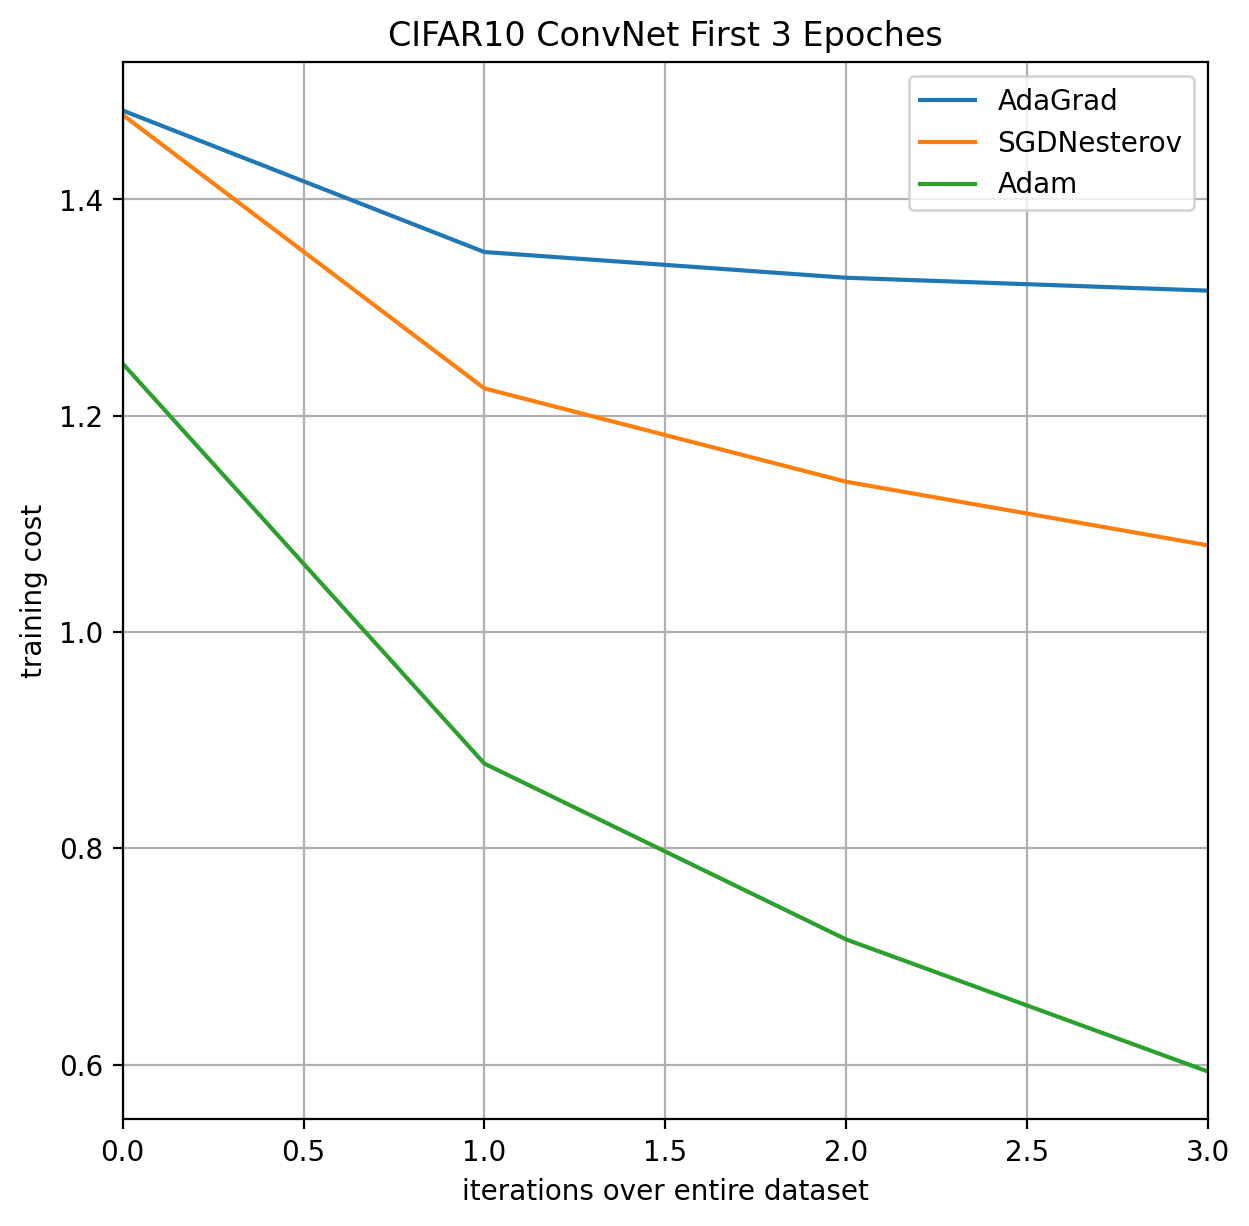

In [11]:
logs = [np.array(logging_Adagrad), np.array(logging_SGDNesterov), np.array(logging_Adam)]
names = ['AdaGrad', 'SGDNesterov', 'Adam']

plt.figure(figsize=(7,7), dpi=200)
for log,name in zip(logs, names):
    plt.plot(log[:4,0], log[:4,1], label=name)
plt.grid(True)
plt.legend()
plt.title('CIFAR10 ConvNet First 3 Epoches')
plt.xlabel('iterations over entire dataset')
plt.ylabel('training cost')
plt.xlim(0,3)
# plt.ylim(0.2)
# plt.yscale('log')
plt.savefig('fig3a.png')
plt.show()

In [12]:
for log,name in zip(logs, names):
    np.save(f'{name}_logging.npy', log)

## CNN with dropout

In [13]:
class CNN_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_dropout, self).__init__()
        self.features = nn.Sequential(         
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64, 1000),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

## Adam+dropout

In [14]:
torch.cuda.set_device(0)
clf_cnn = CNN_dropout(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_cnn.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_cnn(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10
    
opt = torch.optim.Adam(clf_cnn.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()
lambda1 = lambda epoch: 1/np.sqrt(epoch+1)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

logging_Adam_dropout = train(train_loader, test_loader,
                     clf_cnn, criterion, opt, n_epochs=46,
                    scheduler = scheduler)

Number of weights: 4174546


  2%|█▉                                                                                        | 1/46 [00:08<06:41,  8.93s/it]

[Epoch 1] train loss: 1.350; train acc: 0.52; test loss: 1.296; test acc: 0.53


  4%|███▉                                                                                      | 2/46 [00:18<06:36,  9.02s/it]

[Epoch 2] train loss: 1.069; train acc: 0.63; test loss: 1.219; test acc: 0.56


  7%|█████▊                                                                                    | 3/46 [00:26<06:26,  8.99s/it]

[Epoch 3] train loss: 0.973; train acc: 0.66; test loss: 1.130; test acc: 0.60


  9%|███████▊                                                                                  | 4/46 [00:35<06:17,  9.00s/it]

[Epoch 4] train loss: 0.900; train acc: 0.69; test loss: 1.154; test acc: 0.59


 11%|█████████▊                                                                                | 5/46 [00:44<06:08,  8.98s/it]

[Epoch 5] train loss: 0.846; train acc: 0.71; test loss: 1.063; test acc: 0.62


 13%|███████████▋                                                                              | 6/46 [00:53<05:57,  8.95s/it]

[Epoch 6] train loss: 0.809; train acc: 0.72; test loss: 1.048; test acc: 0.63


 15%|█████████████▋                                                                            | 7/46 [01:02<05:48,  8.95s/it]

[Epoch 7] train loss: 0.769; train acc: 0.74; test loss: 1.035; test acc: 0.64


 17%|███████████████▋                                                                          | 8/46 [01:12<05:46,  9.12s/it]

[Epoch 8] train loss: 0.737; train acc: 0.75; test loss: 1.048; test acc: 0.63


 20%|█████████████████▌                                                                        | 9/46 [01:21<05:41,  9.22s/it]

[Epoch 9] train loss: 0.705; train acc: 0.76; test loss: 1.009; test acc: 0.65


 22%|███████████████████▎                                                                     | 10/46 [01:31<05:33,  9.27s/it]

[Epoch 10] train loss: 0.681; train acc: 0.77; test loss: 1.005; test acc: 0.65


 24%|█████████████████████▎                                                                   | 11/46 [01:40<05:27,  9.36s/it]

[Epoch 11] train loss: 0.661; train acc: 0.78; test loss: 0.975; test acc: 0.66


 26%|███████████████████████▏                                                                 | 12/46 [01:48<05:07,  9.04s/it]

[Epoch 12] train loss: 0.634; train acc: 0.79; test loss: 0.947; test acc: 0.67


 28%|█████████████████████████▏                                                               | 13/46 [01:58<05:02,  9.15s/it]

[Epoch 13] train loss: 0.611; train acc: 0.80; test loss: 0.963; test acc: 0.67


 30%|███████████████████████████                                                              | 14/46 [02:07<04:57,  9.28s/it]

[Epoch 14] train loss: 0.593; train acc: 0.81; test loss: 0.970; test acc: 0.67


 33%|█████████████████████████████                                                            | 15/46 [02:16<04:42,  9.12s/it]

[Epoch 15] train loss: 0.577; train acc: 0.81; test loss: 0.953; test acc: 0.67


 35%|██████████████████████████████▉                                                          | 16/46 [02:26<04:35,  9.20s/it]

[Epoch 16] train loss: 0.558; train acc: 0.82; test loss: 0.943; test acc: 0.68


 37%|████████████████████████████████▉                                                        | 17/46 [02:35<04:28,  9.26s/it]

[Epoch 17] train loss: 0.542; train acc: 0.82; test loss: 0.968; test acc: 0.67


 39%|██████████████████████████████████▊                                                      | 18/46 [02:44<04:21,  9.34s/it]

[Epoch 18] train loss: 0.526; train acc: 0.83; test loss: 0.979; test acc: 0.66


 41%|████████████████████████████████████▊                                                    | 19/46 [02:54<04:12,  9.37s/it]

[Epoch 19] train loss: 0.513; train acc: 0.84; test loss: 0.942; test acc: 0.67


 43%|██████████████████████████████████████▋                                                  | 20/46 [03:03<04:04,  9.40s/it]

[Epoch 20] train loss: 0.497; train acc: 0.84; test loss: 0.936; test acc: 0.68


 46%|████████████████████████████████████████▋                                                | 21/46 [03:12<03:52,  9.29s/it]

[Epoch 21] train loss: 0.483; train acc: 0.85; test loss: 0.920; test acc: 0.68


 48%|██████████████████████████████████████████▌                                              | 22/46 [03:22<03:44,  9.37s/it]

[Epoch 22] train loss: 0.469; train acc: 0.85; test loss: 0.927; test acc: 0.68


 50%|████████████████████████████████████████████▌                                            | 23/46 [03:31<03:35,  9.38s/it]

[Epoch 23] train loss: 0.459; train acc: 0.86; test loss: 0.930; test acc: 0.68


 52%|██████████████████████████████████████████████▍                                          | 24/46 [03:40<03:23,  9.24s/it]

[Epoch 24] train loss: 0.447; train acc: 0.86; test loss: 0.927; test acc: 0.68


 54%|████████████████████████████████████████████████▎                                        | 25/46 [03:50<03:16,  9.36s/it]

[Epoch 25] train loss: 0.433; train acc: 0.87; test loss: 0.925; test acc: 0.69


 57%|██████████████████████████████████████████████████▎                                      | 26/46 [03:59<03:08,  9.41s/it]

[Epoch 26] train loss: 0.424; train acc: 0.87; test loss: 0.910; test acc: 0.69


 59%|████████████████████████████████████████████████████▏                                    | 27/46 [04:09<02:59,  9.45s/it]

[Epoch 27] train loss: 0.411; train acc: 0.88; test loss: 0.925; test acc: 0.69


 61%|██████████████████████████████████████████████████████▏                                  | 28/46 [04:18<02:50,  9.46s/it]

[Epoch 28] train loss: 0.401; train acc: 0.88; test loss: 0.905; test acc: 0.69


 63%|████████████████████████████████████████████████████████                                 | 29/46 [04:28<02:41,  9.50s/it]

[Epoch 29] train loss: 0.392; train acc: 0.88; test loss: 0.907; test acc: 0.69


 65%|██████████████████████████████████████████████████████████                               | 30/46 [04:38<02:32,  9.55s/it]

[Epoch 30] train loss: 0.381; train acc: 0.89; test loss: 0.908; test acc: 0.69


 67%|███████████████████████████████████████████████████████████▉                             | 31/46 [04:47<02:23,  9.56s/it]

[Epoch 31] train loss: 0.370; train acc: 0.89; test loss: 0.922; test acc: 0.69


 70%|█████████████████████████████████████████████████████████████▉                           | 32/46 [04:57<02:13,  9.55s/it]

[Epoch 32] train loss: 0.365; train acc: 0.89; test loss: 0.902; test acc: 0.70


 72%|███████████████████████████████████████████████████████████████▊                         | 33/46 [05:06<02:02,  9.45s/it]

[Epoch 33] train loss: 0.353; train acc: 0.90; test loss: 0.901; test acc: 0.70


 74%|█████████████████████████████████████████████████████████████████▊                       | 34/46 [05:16<01:53,  9.46s/it]

[Epoch 34] train loss: 0.344; train acc: 0.90; test loss: 0.897; test acc: 0.70


 76%|███████████████████████████████████████████████████████████████████▋                     | 35/46 [05:25<01:44,  9.51s/it]

[Epoch 35] train loss: 0.336; train acc: 0.90; test loss: 0.896; test acc: 0.70


 78%|█████████████████████████████████████████████████████████████████████▋                   | 36/46 [05:35<01:34,  9.48s/it]

[Epoch 36] train loss: 0.328; train acc: 0.91; test loss: 0.907; test acc: 0.70


 80%|███████████████████████████████████████████████████████████████████████▌                 | 37/46 [05:44<01:25,  9.48s/it]

[Epoch 37] train loss: 0.319; train acc: 0.91; test loss: 0.907; test acc: 0.70


 83%|█████████████████████████████████████████████████████████████████████████▌               | 38/46 [05:54<01:16,  9.51s/it]

[Epoch 38] train loss: 0.310; train acc: 0.91; test loss: 0.928; test acc: 0.69


 85%|███████████████████████████████████████████████████████████████████████████▍             | 39/46 [06:03<01:06,  9.51s/it]

[Epoch 39] train loss: 0.305; train acc: 0.91; test loss: 0.899; test acc: 0.70


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 40/46 [06:12<00:56,  9.45s/it]

[Epoch 40] train loss: 0.299; train acc: 0.92; test loss: 0.895; test acc: 0.70


 89%|███████████████████████████████████████████████████████████████████████████████▎         | 41/46 [06:22<00:47,  9.48s/it]

[Epoch 41] train loss: 0.290; train acc: 0.92; test loss: 0.912; test acc: 0.70


 91%|█████████████████████████████████████████████████████████████████████████████████▎       | 42/46 [06:31<00:37,  9.35s/it]

[Epoch 42] train loss: 0.283; train acc: 0.92; test loss: 0.872; test acc: 0.71


 93%|███████████████████████████████████████████████████████████████████████████████████▏     | 43/46 [06:41<00:28,  9.41s/it]

[Epoch 43] train loss: 0.273; train acc: 0.93; test loss: 0.871; test acc: 0.71


 96%|█████████████████████████████████████████████████████████████████████████████████████▏   | 44/46 [06:50<00:18,  9.47s/it]

[Epoch 44] train loss: 0.273; train acc: 0.93; test loss: 0.895; test acc: 0.71


 98%|███████████████████████████████████████████████████████████████████████████████████████  | 45/46 [06:59<00:09,  9.29s/it]

[Epoch 45] train loss: 0.263; train acc: 0.93; test loss: 0.905; test acc: 0.70


100%|█████████████████████████████████████████████████████████████████████████████████████████| 46/46 [07:09<00:00,  9.33s/it]

[Epoch 46] train loss: 0.258; train acc: 0.93; test loss: 0.896; test acc: 0.70


## Adagrad+dropout

In [15]:
torch.cuda.set_device(0)
clf_cnn = CNN_dropout(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_cnn.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_cnn(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10
    
opt = torch.optim.Adagrad(clf_cnn.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

lambda1 = lambda epoch: 1/np.sqrt(epoch+1)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
logging_Adagrad_dropout = train(train_loader, test_loader,
                        clf_cnn, criterion, opt, n_epochs=46,
                       scheduler=scheduler)

Number of weights: 4174546


  2%|█▉                                                                                        | 1/46 [00:08<06:18,  8.41s/it]

[Epoch 1] train loss: 1.578; train acc: 0.44; test loss: 1.620; test acc: 0.42


  4%|███▉                                                                                      | 2/46 [00:16<06:09,  8.40s/it]

[Epoch 2] train loss: 1.490; train acc: 0.47; test loss: 1.592; test acc: 0.43


  7%|█████▊                                                                                    | 3/46 [00:25<05:59,  8.36s/it]

[Epoch 3] train loss: 1.471; train acc: 0.48; test loss: 1.566; test acc: 0.44


  9%|███████▊                                                                                  | 4/46 [00:33<05:53,  8.41s/it]

[Epoch 4] train loss: 1.459; train acc: 0.49; test loss: 1.566; test acc: 0.44


 11%|█████████▊                                                                                | 5/46 [00:41<05:42,  8.35s/it]

[Epoch 5] train loss: 1.450; train acc: 0.49; test loss: 1.586; test acc: 0.43


 13%|███████████▋                                                                              | 6/46 [00:50<05:33,  8.34s/it]

[Epoch 6] train loss: 1.443; train acc: 0.49; test loss: 1.567; test acc: 0.44


 15%|█████████████▋                                                                            | 7/46 [00:58<05:27,  8.40s/it]

[Epoch 7] train loss: 1.440; train acc: 0.49; test loss: 1.572; test acc: 0.43


 17%|███████████████▋                                                                          | 8/46 [01:06<05:18,  8.37s/it]

[Epoch 8] train loss: 1.435; train acc: 0.49; test loss: 1.548; test acc: 0.44


 20%|█████████████████▌                                                                        | 9/46 [01:15<05:11,  8.42s/it]

[Epoch 9] train loss: 1.430; train acc: 0.50; test loss: 1.561; test acc: 0.44


 22%|███████████████████▎                                                                     | 10/46 [01:24<05:04,  8.47s/it]

[Epoch 10] train loss: 1.427; train acc: 0.50; test loss: 1.574; test acc: 0.43


 24%|█████████████████████▎                                                                   | 11/46 [01:32<04:56,  8.46s/it]

[Epoch 11] train loss: 1.422; train acc: 0.50; test loss: 1.561; test acc: 0.44


 26%|███████████████████████▏                                                                 | 12/46 [01:41<04:49,  8.52s/it]

[Epoch 12] train loss: 1.421; train acc: 0.50; test loss: 1.567; test acc: 0.43


 28%|█████████████████████████▏                                                               | 13/46 [01:49<04:41,  8.53s/it]

[Epoch 13] train loss: 1.420; train acc: 0.50; test loss: 1.565; test acc: 0.43


 30%|███████████████████████████                                                              | 14/46 [01:58<04:32,  8.52s/it]

[Epoch 14] train loss: 1.419; train acc: 0.50; test loss: 1.561; test acc: 0.44


 33%|█████████████████████████████                                                            | 15/46 [02:06<04:24,  8.53s/it]

[Epoch 15] train loss: 1.418; train acc: 0.50; test loss: 1.537; test acc: 0.45


 35%|██████████████████████████████▉                                                          | 16/46 [02:15<04:14,  8.49s/it]

[Epoch 16] train loss: 1.418; train acc: 0.50; test loss: 1.549; test acc: 0.44


 37%|████████████████████████████████▉                                                        | 17/46 [02:23<04:08,  8.57s/it]

[Epoch 17] train loss: 1.411; train acc: 0.50; test loss: 1.560; test acc: 0.44


 39%|██████████████████████████████████▊                                                      | 18/46 [02:32<04:03,  8.71s/it]

[Epoch 18] train loss: 1.411; train acc: 0.50; test loss: 1.556; test acc: 0.44


 41%|████████████████████████████████████▊                                                    | 19/46 [02:41<03:55,  8.74s/it]

[Epoch 19] train loss: 1.411; train acc: 0.50; test loss: 1.553; test acc: 0.44


 43%|██████████████████████████████████████▋                                                  | 20/46 [02:50<03:47,  8.75s/it]

[Epoch 20] train loss: 1.412; train acc: 0.50; test loss: 1.552; test acc: 0.44


 46%|████████████████████████████████████████▋                                                | 21/46 [02:59<03:41,  8.85s/it]

[Epoch 21] train loss: 1.409; train acc: 0.50; test loss: 1.545; test acc: 0.44


 48%|██████████████████████████████████████████▌                                              | 22/46 [03:08<03:29,  8.74s/it]

[Epoch 22] train loss: 1.407; train acc: 0.50; test loss: 1.556; test acc: 0.44


 50%|████████████████████████████████████████████▌                                            | 23/46 [03:16<03:19,  8.67s/it]

[Epoch 23] train loss: 1.406; train acc: 0.50; test loss: 1.553; test acc: 0.44


 52%|██████████████████████████████████████████████▍                                          | 24/46 [03:25<03:10,  8.66s/it]

[Epoch 24] train loss: 1.404; train acc: 0.50; test loss: 1.553; test acc: 0.44


 54%|████████████████████████████████████████████████▎                                        | 25/46 [03:33<02:59,  8.57s/it]

[Epoch 25] train loss: 1.403; train acc: 0.51; test loss: 1.536; test acc: 0.45


 57%|██████████████████████████████████████████████████▎                                      | 26/46 [03:42<02:52,  8.65s/it]

[Epoch 26] train loss: 1.403; train acc: 0.51; test loss: 1.545; test acc: 0.44


 59%|████████████████████████████████████████████████████▏                                    | 27/46 [03:51<02:45,  8.69s/it]

[Epoch 27] train loss: 1.402; train acc: 0.50; test loss: 1.526; test acc: 0.45


 61%|██████████████████████████████████████████████████████▏                                  | 28/46 [03:59<02:35,  8.66s/it]

[Epoch 28] train loss: 1.403; train acc: 0.50; test loss: 1.547; test acc: 0.44


 63%|████████████████████████████████████████████████████████                                 | 29/46 [04:08<02:25,  8.55s/it]

[Epoch 29] train loss: 1.399; train acc: 0.51; test loss: 1.538; test acc: 0.45


 65%|██████████████████████████████████████████████████████████                               | 30/46 [04:16<02:17,  8.56s/it]

[Epoch 30] train loss: 1.398; train acc: 0.51; test loss: 1.554; test acc: 0.44


 67%|███████████████████████████████████████████████████████████▉                             | 31/46 [04:25<02:08,  8.55s/it]

[Epoch 31] train loss: 1.401; train acc: 0.51; test loss: 1.553; test acc: 0.44


 70%|█████████████████████████████████████████████████████████████▉                           | 32/46 [04:34<02:01,  8.66s/it]

[Epoch 32] train loss: 1.403; train acc: 0.51; test loss: 1.540; test acc: 0.44


 72%|███████████████████████████████████████████████████████████████▊                         | 33/46 [04:42<01:51,  8.58s/it]

[Epoch 33] train loss: 1.399; train acc: 0.51; test loss: 1.546; test acc: 0.44


 74%|█████████████████████████████████████████████████████████████████▊                       | 34/46 [04:51<01:43,  8.58s/it]

[Epoch 34] train loss: 1.396; train acc: 0.51; test loss: 1.532; test acc: 0.45


 76%|███████████████████████████████████████████████████████████████████▋                     | 35/46 [04:59<01:34,  8.62s/it]

[Epoch 35] train loss: 1.397; train acc: 0.51; test loss: 1.553; test acc: 0.44


 78%|█████████████████████████████████████████████████████████████████████▋                   | 36/46 [05:08<01:27,  8.71s/it]

[Epoch 36] train loss: 1.393; train acc: 0.51; test loss: 1.529; test acc: 0.45


 80%|███████████████████████████████████████████████████████████████████████▌                 | 37/46 [05:17<01:18,  8.72s/it]

[Epoch 37] train loss: 1.396; train acc: 0.51; test loss: 1.543; test acc: 0.44


 83%|█████████████████████████████████████████████████████████████████████████▌               | 38/46 [05:26<01:10,  8.78s/it]

[Epoch 38] train loss: 1.395; train acc: 0.51; test loss: 1.548; test acc: 0.44


 85%|███████████████████████████████████████████████████████████████████████████▍             | 39/46 [05:35<01:01,  8.72s/it]

[Epoch 39] train loss: 1.393; train acc: 0.51; test loss: 1.541; test acc: 0.44


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 40/46 [05:43<00:52,  8.75s/it]

[Epoch 40] train loss: 1.390; train acc: 0.51; test loss: 1.538; test acc: 0.44


 89%|███████████████████████████████████████████████████████████████████████████████▎         | 41/46 [05:52<00:43,  8.68s/it]

[Epoch 41] train loss: 1.392; train acc: 0.51; test loss: 1.522; test acc: 0.45


 91%|█████████████████████████████████████████████████████████████████████████████████▎       | 42/46 [06:01<00:34,  8.70s/it]

[Epoch 42] train loss: 1.392; train acc: 0.51; test loss: 1.537; test acc: 0.45


 93%|███████████████████████████████████████████████████████████████████████████████████▏     | 43/46 [06:09<00:25,  8.66s/it]

[Epoch 43] train loss: 1.388; train acc: 0.51; test loss: 1.528; test acc: 0.45


 96%|█████████████████████████████████████████████████████████████████████████████████████▏   | 44/46 [06:18<00:17,  8.62s/it]

[Epoch 44] train loss: 1.390; train acc: 0.51; test loss: 1.535; test acc: 0.45


 98%|███████████████████████████████████████████████████████████████████████████████████████  | 45/46 [06:26<00:08,  8.65s/it]

[Epoch 45] train loss: 1.390; train acc: 0.51; test loss: 1.519; test acc: 0.45


100%|█████████████████████████████████████████████████████████████████████████████████████████| 46/46 [06:35<00:00,  8.60s/it]

[Epoch 46] train loss: 1.389; train acc: 0.51; test loss: 1.519; test acc: 0.45


## SGDNesterov+dropout

In [16]:
torch.cuda.set_device(0)
clf_cnn = CNN(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_cnn.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_cnn(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10
    
opt = torch.optim.SGD(clf_cnn.parameters(), lr=LR, nesterov=True, momentum=0.95)
criterion = torch.nn.CrossEntropyLoss()
lambda1 = lambda epoch: 1/np.sqrt(epoch+1)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

logging_SGDNesterov_dropout = train(train_loader, test_loader,
                            clf_cnn, criterion, opt, n_epochs=46,
                           scheduler=scheduler)

Number of weights: 4174546


  2%|█▉                                                                                        | 1/46 [00:07<05:52,  7.84s/it]

[Epoch 1] train loss: 1.474; train acc: 0.48; test loss: 1.306; test acc: 0.54


  4%|███▉                                                                                      | 2/46 [00:16<05:56,  8.11s/it]

[Epoch 2] train loss: 1.229; train acc: 0.57; test loss: 1.238; test acc: 0.56


  7%|█████▊                                                                                    | 3/46 [00:24<05:45,  8.04s/it]

[Epoch 3] train loss: 1.149; train acc: 0.60; test loss: 1.184; test acc: 0.58


  9%|███████▊                                                                                  | 4/46 [00:32<05:37,  8.03s/it]

[Epoch 4] train loss: 1.093; train acc: 0.62; test loss: 1.151; test acc: 0.60


 11%|█████████▊                                                                                | 5/46 [00:40<05:29,  8.03s/it]

[Epoch 5] train loss: 1.054; train acc: 0.64; test loss: 1.127; test acc: 0.61


 13%|███████████▋                                                                              | 6/46 [00:48<05:20,  8.00s/it]

[Epoch 6] train loss: 1.017; train acc: 0.65; test loss: 1.104; test acc: 0.61


 15%|█████████████▋                                                                            | 7/46 [00:56<05:13,  8.03s/it]

[Epoch 7] train loss: 0.987; train acc: 0.66; test loss: 1.088; test acc: 0.62


 17%|███████████████▋                                                                          | 8/46 [01:04<05:07,  8.08s/it]

[Epoch 8] train loss: 0.962; train acc: 0.67; test loss: 1.072; test acc: 0.62


 20%|█████████████████▌                                                                        | 9/46 [01:12<05:00,  8.11s/it]

[Epoch 9] train loss: 0.939; train acc: 0.68; test loss: 1.056; test acc: 0.63


 22%|███████████████████▎                                                                     | 10/46 [01:20<04:51,  8.09s/it]

[Epoch 10] train loss: 0.919; train acc: 0.69; test loss: 1.045; test acc: 0.63


 24%|█████████████████████▎                                                                   | 11/46 [01:28<04:42,  8.08s/it]

[Epoch 11] train loss: 0.903; train acc: 0.70; test loss: 1.032; test acc: 0.64


 26%|███████████████████████▏                                                                 | 12/46 [01:36<04:32,  8.03s/it]

[Epoch 12] train loss: 0.883; train acc: 0.71; test loss: 1.024; test acc: 0.64


 28%|█████████████████████████▏                                                               | 13/46 [01:44<04:26,  8.09s/it]

[Epoch 13] train loss: 0.867; train acc: 0.71; test loss: 1.016; test acc: 0.65


 30%|███████████████████████████                                                              | 14/46 [01:52<04:17,  8.04s/it]

[Epoch 14] train loss: 0.853; train acc: 0.72; test loss: 1.011; test acc: 0.65


 33%|█████████████████████████████                                                            | 15/46 [02:00<04:07,  7.99s/it]

[Epoch 15] train loss: 0.839; train acc: 0.72; test loss: 1.002; test acc: 0.65


 35%|██████████████████████████████▉                                                          | 16/46 [02:08<03:59,  7.98s/it]

[Epoch 16] train loss: 0.827; train acc: 0.73; test loss: 0.995; test acc: 0.65


 37%|████████████████████████████████▉                                                        | 17/46 [02:16<03:52,  8.03s/it]

[Epoch 17] train loss: 0.814; train acc: 0.73; test loss: 0.989; test acc: 0.66


 39%|██████████████████████████████████▊                                                      | 18/46 [02:24<03:45,  8.06s/it]

[Epoch 18] train loss: 0.802; train acc: 0.74; test loss: 0.988; test acc: 0.66


 41%|████████████████████████████████████▊                                                    | 19/46 [02:33<03:39,  8.11s/it]

[Epoch 19] train loss: 0.793; train acc: 0.74; test loss: 0.981; test acc: 0.66


 43%|██████████████████████████████████████▋                                                  | 20/46 [02:41<03:33,  8.21s/it]

[Epoch 20] train loss: 0.782; train acc: 0.74; test loss: 0.974; test acc: 0.66


 46%|████████████████████████████████████████▋                                                | 21/46 [02:49<03:24,  8.18s/it]

[Epoch 21] train loss: 0.770; train acc: 0.75; test loss: 0.970; test acc: 0.66


 48%|██████████████████████████████████████████▌                                              | 22/46 [02:57<03:16,  8.19s/it]

[Epoch 22] train loss: 0.763; train acc: 0.75; test loss: 0.966; test acc: 0.66


 50%|████████████████████████████████████████████▌                                            | 23/46 [03:06<03:09,  8.25s/it]

[Epoch 23] train loss: 0.752; train acc: 0.75; test loss: 0.965; test acc: 0.67


 52%|██████████████████████████████████████████████▍                                          | 24/46 [03:14<03:03,  8.33s/it]

[Epoch 24] train loss: 0.744; train acc: 0.76; test loss: 0.960; test acc: 0.67


 54%|████████████████████████████████████████████████▎                                        | 25/46 [03:23<02:56,  8.39s/it]

[Epoch 25] train loss: 0.736; train acc: 0.76; test loss: 0.958; test acc: 0.67


 57%|██████████████████████████████████████████████████▎                                      | 26/46 [03:31<02:47,  8.36s/it]

[Epoch 26] train loss: 0.727; train acc: 0.76; test loss: 0.952; test acc: 0.67


 59%|████████████████████████████████████████████████████▏                                    | 27/46 [03:39<02:39,  8.39s/it]

[Epoch 27] train loss: 0.718; train acc: 0.77; test loss: 0.950; test acc: 0.67


 61%|██████████████████████████████████████████████████████▏                                  | 28/46 [03:47<02:28,  8.27s/it]

[Epoch 28] train loss: 0.711; train acc: 0.77; test loss: 0.947; test acc: 0.67


 63%|████████████████████████████████████████████████████████                                 | 29/46 [03:56<02:20,  8.28s/it]

[Epoch 29] train loss: 0.706; train acc: 0.77; test loss: 0.943; test acc: 0.67


 65%|██████████████████████████████████████████████████████████                               | 30/46 [04:04<02:13,  8.34s/it]

[Epoch 30] train loss: 0.698; train acc: 0.77; test loss: 0.946; test acc: 0.67


 67%|███████████████████████████████████████████████████████████▉                             | 31/46 [04:13<02:05,  8.36s/it]

[Epoch 31] train loss: 0.689; train acc: 0.78; test loss: 0.939; test acc: 0.68


 70%|█████████████████████████████████████████████████████████████▉                           | 32/46 [04:21<01:57,  8.37s/it]

[Epoch 32] train loss: 0.682; train acc: 0.78; test loss: 0.939; test acc: 0.67


 72%|███████████████████████████████████████████████████████████████▊                         | 33/46 [04:29<01:48,  8.33s/it]

[Epoch 33] train loss: 0.676; train acc: 0.78; test loss: 0.936; test acc: 0.68


 74%|█████████████████████████████████████████████████████████████████▊                       | 34/46 [04:38<01:39,  8.31s/it]

[Epoch 34] train loss: 0.668; train acc: 0.79; test loss: 0.933; test acc: 0.68


 76%|███████████████████████████████████████████████████████████████████▋                     | 35/46 [04:46<01:32,  8.37s/it]

[Epoch 35] train loss: 0.662; train acc: 0.79; test loss: 0.933; test acc: 0.68


 78%|█████████████████████████████████████████████████████████████████████▋                   | 36/46 [04:55<01:24,  8.40s/it]

[Epoch 36] train loss: 0.656; train acc: 0.79; test loss: 0.931; test acc: 0.68


 80%|███████████████████████████████████████████████████████████████████████▌                 | 37/46 [05:03<01:15,  8.34s/it]

[Epoch 37] train loss: 0.649; train acc: 0.79; test loss: 0.928; test acc: 0.68


 83%|█████████████████████████████████████████████████████████████████████████▌               | 38/46 [05:11<01:06,  8.26s/it]

[Epoch 38] train loss: 0.644; train acc: 0.80; test loss: 0.924; test acc: 0.68


 85%|███████████████████████████████████████████████████████████████████████████▍             | 39/46 [05:19<00:57,  8.24s/it]

[Epoch 39] train loss: 0.638; train acc: 0.80; test loss: 0.926; test acc: 0.68


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 40/46 [05:27<00:49,  8.31s/it]

[Epoch 40] train loss: 0.631; train acc: 0.80; test loss: 0.925; test acc: 0.68


 89%|███████████████████████████████████████████████████████████████████████████████▎         | 41/46 [05:36<00:41,  8.34s/it]

[Epoch 41] train loss: 0.627; train acc: 0.80; test loss: 0.925; test acc: 0.68


 91%|█████████████████████████████████████████████████████████████████████████████████▎       | 42/46 [05:44<00:33,  8.38s/it]

[Epoch 42] train loss: 0.621; train acc: 0.80; test loss: 0.924; test acc: 0.68


 93%|███████████████████████████████████████████████████████████████████████████████████▏     | 43/46 [05:53<00:25,  8.43s/it]

[Epoch 43] train loss: 0.617; train acc: 0.81; test loss: 0.920; test acc: 0.68


 96%|█████████████████████████████████████████████████████████████████████████████████████▏   | 44/46 [06:01<00:16,  8.40s/it]

[Epoch 44] train loss: 0.610; train acc: 0.81; test loss: 0.917; test acc: 0.68


 98%|███████████████████████████████████████████████████████████████████████████████████████  | 45/46 [06:09<00:08,  8.31s/it]

[Epoch 45] train loss: 0.603; train acc: 0.81; test loss: 0.918; test acc: 0.68


100%|█████████████████████████████████████████████████████████████████████████████████████████| 46/46 [06:18<00:00,  8.22s/it]

[Epoch 46] train loss: 0.600; train acc: 0.81; test loss: 0.917; test acc: 0.68


## Optimizers comparing plot

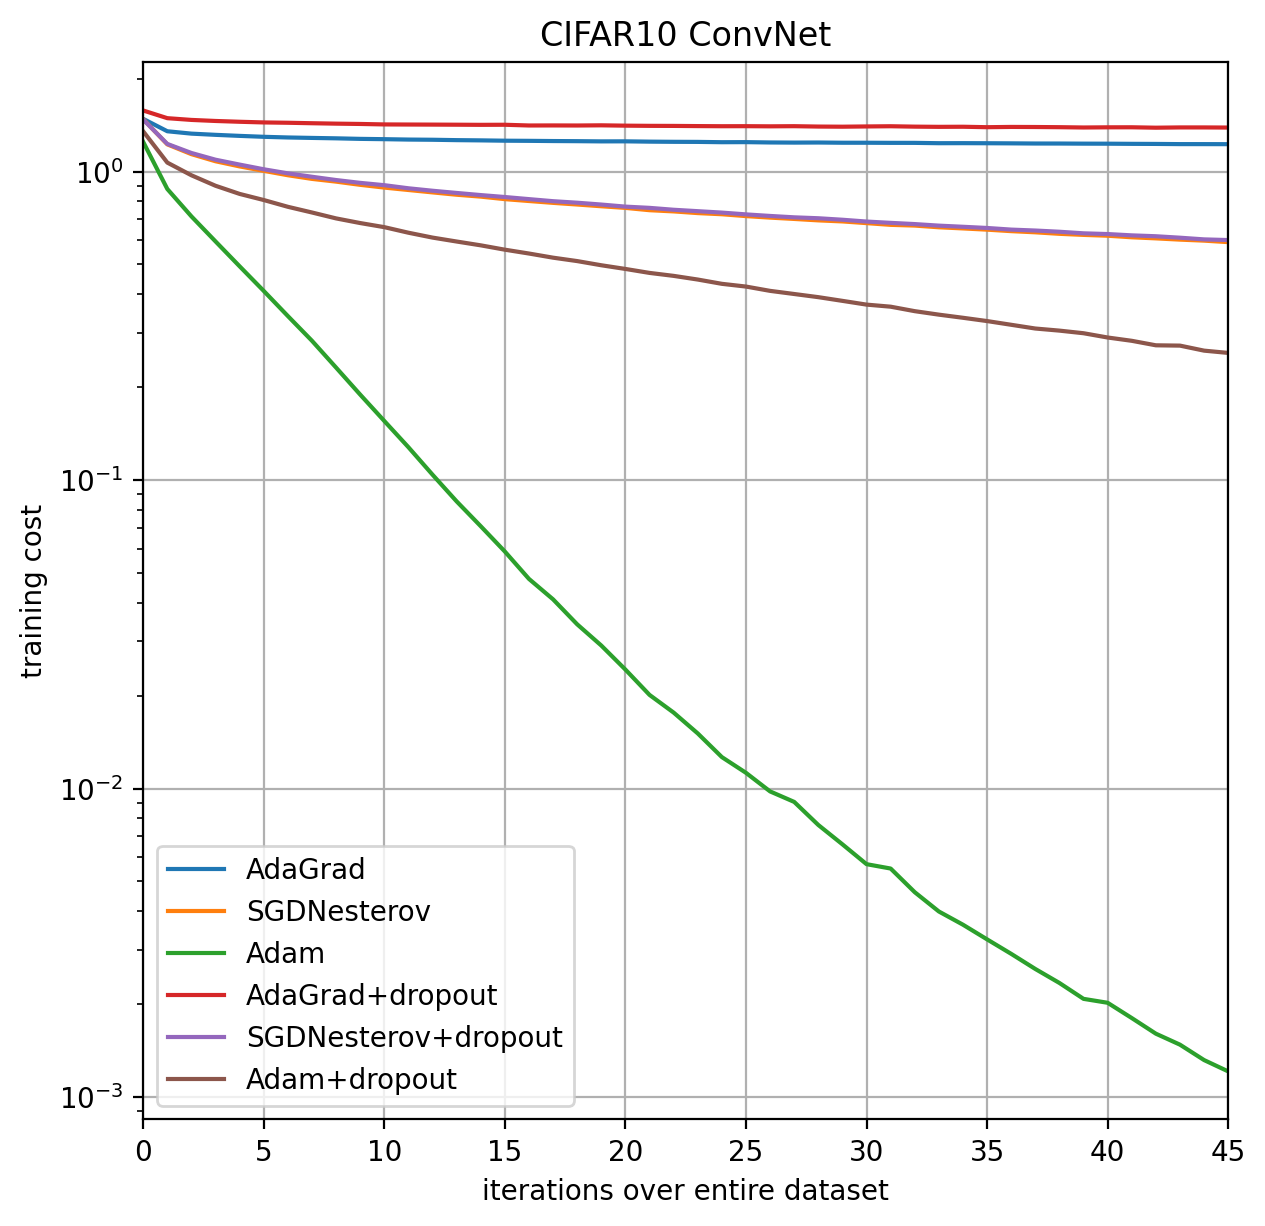

In [17]:
logs = [np.array(logging_Adagrad), np.array(logging_SGDNesterov), np.array(logging_Adam),
       np.array(logging_Adagrad_dropout), np.array(logging_SGDNesterov_dropout), np.array(logging_Adam_dropout)]
names = ['AdaGrad', 'SGDNesterov', 'Adam',
        'AdaGrad+dropout', 'SGDNesterov+dropout', 'Adam+dropout']

plt.figure(figsize=(7,7), dpi=200)
for log,name in zip(logs, names):
    plt.plot(log[:,0], log[:,1], label=name)
plt.grid(True)
plt.legend()
plt.title('CIFAR10 ConvNet')
plt.xlabel('iterations over entire dataset')
plt.ylabel('training cost')
plt.xlim(0,45)
# plt.ylim(0.2)
plt.yscale('log')
plt.savefig('fig3b_full.png')
plt.show()

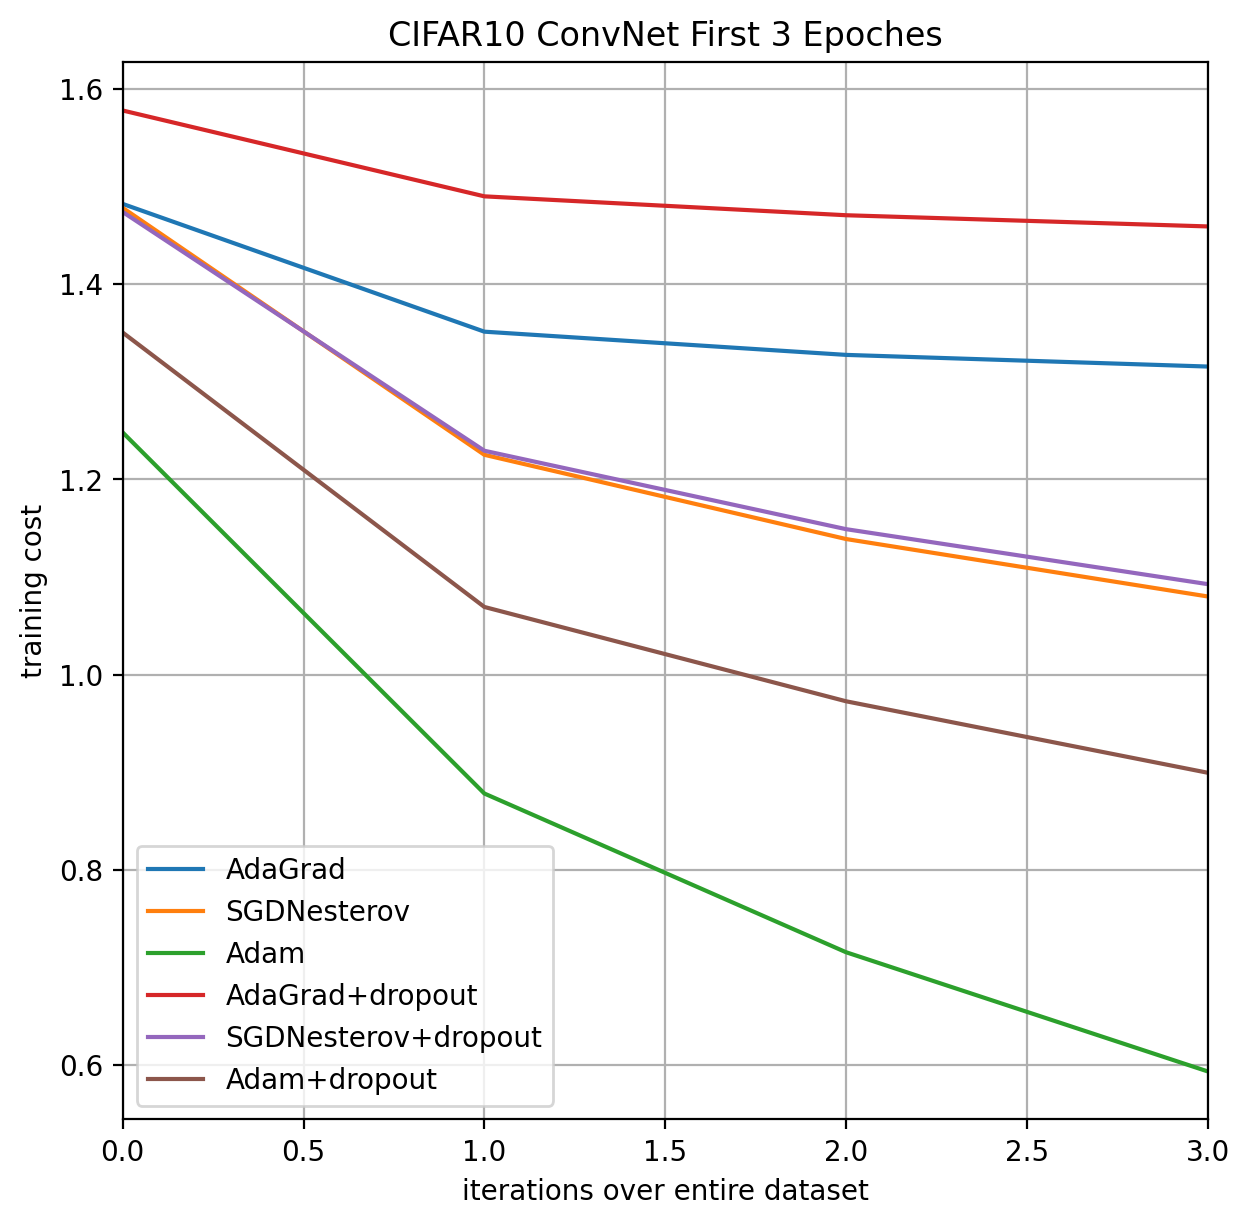

In [18]:
plt.figure(figsize=(7,7), dpi=200)
for log,name in zip(logs, names):
    plt.plot(log[:4,0], log[:4,1], label=name)
plt.grid(True)
plt.legend()
plt.title('CIFAR10 ConvNet First 3 Epoches')
plt.xlabel('iterations over entire dataset')
plt.ylabel('training cost')
plt.xlim(0,3)
# plt.ylim(0.2)
# plt.yscale('log')
plt.savefig('fig3a_full.png')
plt.show()